In [1]:
from greenbutton import parse

In [2]:
parsedDatas = parse.parse_feed('/Users/arian/Documents/greenbutton-python/testdata/Alectra_Electric_2024-01-19-2025-01-19.xml')

In [3]:
parsedData = parsedDatas[0]

In [4]:
meterReadings = list(parsedData.meterReadings)

In [5]:
meterReading = meterReadings[0]

In [6]:
intervalBlocks = meterReading.intervalBlocks

In [7]:
len(intervalBlocks)
# there is one intervalBlock for each day

366

In [8]:
intervalBlock = intervalBlocks[-1]

In [9]:
intervalReadings = intervalBlock.intervalReadings

In [10]:
len(intervalReadings)
# there is one intervalReading for each hour

24

In [11]:
intervalReading = intervalReadings[-1]

In [12]:
intervalReading.value, intervalReading.value_symbol, '@', intervalReading.cost, intervalReading.cost_symbol

(510.0, 'Wh', '@', 0.076, '$')

In [13]:
# tou: 3=off-peak, 2=mid-peak, 1=on-peak
# selectedIntervalReading.tou

In [14]:
onPeak = [intervalReading 
          for intervalBlock in intervalBlocks[1:] 
          for intervalReading in intervalBlock.intervalReadings
          if intervalReading.tou == 1]
midPeak = [intervalReading 
          for intervalBlock in intervalBlocks[1:] 
          for intervalReading in intervalBlock.intervalReadings
          if intervalReading.tou == 2]
offPeak = [intervalReading 
          for intervalBlock in intervalBlocks[1:] 
          for intervalReading in intervalBlock.intervalReadings
          if intervalReading.tou == 3]

In [15]:
class DataPoint:
    def __init__(self, date, tou1, tou2, tou3, onCost, midCost, offCost):
        self.date = date
        self.onPeak = tou1
        self.midPeak = tou2
        self.offPeak = tou3
        self.onCost = onCost
        self.midCost = midCost
        self.offCost = offCost

In [16]:
dataPoints = []

In [17]:
for intervalReading in onPeak:
    value = intervalReading.value/1000
    price = intervalReading.cost
    cost = value*price
    dataPoints.append(DataPoint(intervalReading.timePeriod.start, value, 0, 0, cost, 0, 0))

In [18]:
for intervalReading in midPeak:
    value = intervalReading.value/1000
    price = intervalReading.cost
    cost = value*price
    dataPoints.append(DataPoint(intervalReading.timePeriod.start, 0, value, 0, 0, cost, 0))

In [19]:
for intervalReading in offPeak:
    value = intervalReading.value/1000
    price = intervalReading.cost
    cost = value*price
    dataPoints.append(DataPoint(intervalReading.timePeriod.start, 0, 0, value, 0, 0, cost))

In [20]:
len(dataPoints)

8759

In [21]:
data_dict = {
    'date': [point.date for point in dataPoints],
    'onPeak': [point.onPeak for point in dataPoints],
    'midPeak': [point.midPeak for point in dataPoints],
    'offPeak': [point.offPeak for point in dataPoints],
    'onCost': [point.onCost for point in dataPoints],
    'midCost': [point.midCost for point in dataPoints],
    'offCost': [point.offCost for point in dataPoints],
}

In [22]:
import pandas as pd

In [23]:
df = pd.DataFrame(data_dict)

In [24]:
df.sort_values(by='date', inplace=True)

In [25]:
df = df.reset_index(drop=True)

In [26]:
df['date'] = df['date'].dt.tz_convert('America/Vancouver')
# for some reason my power company gives the time in PST

In [27]:
df['group_key'] = df['date'].dt.to_period('D')
df.drop('date', axis=1, inplace=True)
grouping = df.groupby('group_key').sum()
grouping = grouping.reset_index()
grouping['total'] = (grouping['onPeak'] + grouping['midPeak'] + grouping['offPeak'])
grouping['totalCost'] = (grouping['onCost'] + grouping['midCost'] + grouping['offCost'])

/var/folders/fc/lrm7xw097cn10lqtth3cq8880000gn/T/ipykernel_98760/3816791393.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['group_key'] = df['date'].dt.to_period('D')


In [28]:
grouping = grouping[1:-1]

In [29]:
subselection = grouping[:31]
#subselection.head(3)

In [30]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np

In [31]:
x = subselection['group_key'].astype(str).tolist()
y1 = subselection['onPeak'].to_numpy()
y2 = subselection['midPeak'].to_numpy()
y3 = subselection['offPeak'].to_numpy()

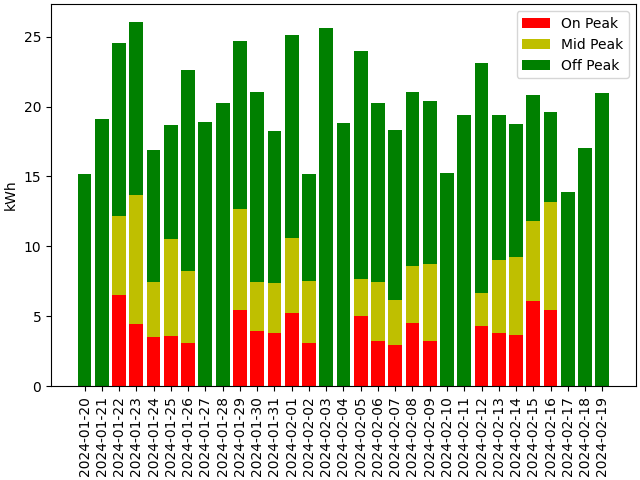

In [32]:
plt.figure(constrained_layout=True)
plt.bar(x, y1, color='r')
plt.bar(x, y2, bottom=y1, color='y')
plt.bar(x, y3, bottom=y1+y2, color='g')
plt.xticks(rotation=90)
plt.ylabel("kWh")
plt.legend(["On Peak", "Mid Peak", "Off Peak"])
plt.show()